# Learning the Half Moons Distribution

Simple example of 2d synthetic data of two interwoven 'half moons'. Great for getting started with Multiplicative Normalizing Flows.

In [ ]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.collections import LineCollection
from torch.distributions import MultivariateNormal
from tqdm import trange

import torch_mnf.flows as nf
from torch_mnf import data
from torch_mnf.utils import ROOT, interruptible

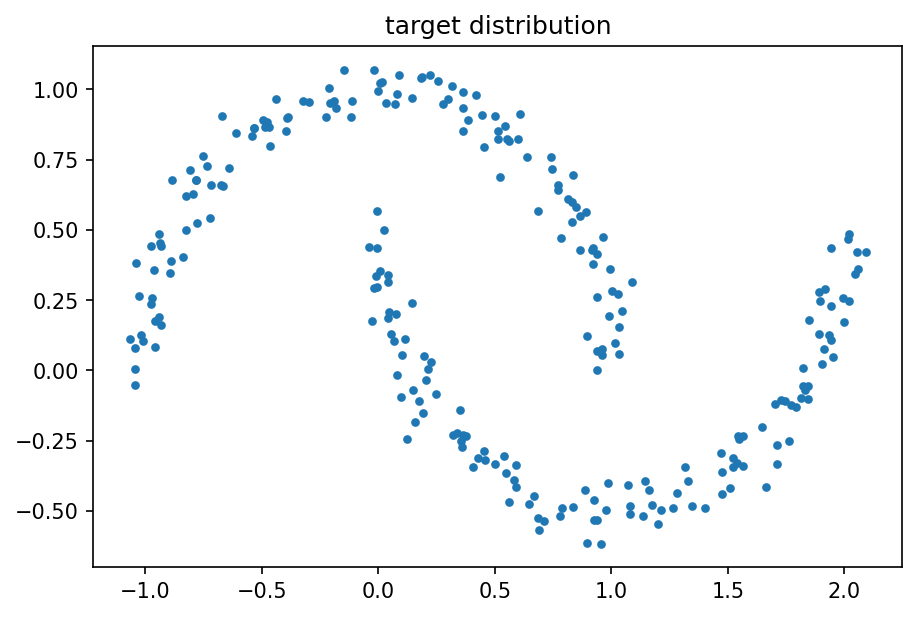

In [ ]:
torch.manual_seed(0)  # ensure reproducible results

plt.rc("savefig", bbox="tight", dpi=200)
plt.rcParams["figure.constrained_layout.use"] = True
plt.rc("figure", dpi=150)

sample_target_dist = data.sample_moons
samples = sample_target_dist(256)
plt.title("target distribution")
plt.scatter(*samples.T, s=10)

In [ ]:
# Construct the base distribution for a normalizing flow model.
base = MultivariateNormal(torch.zeros(2), torch.eye(2))

In [ ]:
# Construct the flow.
flows = [nf.AffineHalfFlow(dim=2, parity=bool(i % 2)) for i in range(9)]


# # %% -- NICE --
# flows = [nf.AffineHalfFlow(dim=2, parity=i % 2, scale=False) for i in range(4)]
# flows.append(nf.AffineConstantFlow(dim=2, shift=False))


# # %% -- MAF --
# # for fast density estimation
# flows = [nf.MAF(dim=2, parity=bool(i % 2)) for i in range(9)]


# # %% -- IAF --
# # for fast sampling
# flows = [nf.IAF(dim=2, parity=bool(i % 2)) for i in range(9)]

In [ ]:
# prepend ActNormFlows to every layer in any of the flows above
# for idx in reversed(range(len(flows))):
#     flows.insert(idx, nf.ActNormFlow(dim=2))


# # %% -- Glow --
# flows = [nf.Glow(dim=2) for _ in range(3)]
# # prepend each Glow (1x1 convolution) with ActNormFlow and append with AffineHalfFlow
# for idx in reversed(range(len(flows))):
#     flows.insert(idx, nf.ActNormFlow(dim=2))
#     flows.insert(idx + 2, nf.AffineHalfFlow(dim=2, parity=idx % 2, nh=32))

In [ ]:
# flows = [nf.NSF_AR(dim=2, K=8, B=3, n_h=16) for _ in range(3)]
# # prepend each NSF flow with ActNormFlow and Glow
# for idx in reversed(range(len(flows))):
#     flows.insert(idx, nf.ActNormFlow(dim=2))
#     flows.insert(idx + 1, nf.Glow(dim=2))

In [ ]:
# Construct the flow model.
model = nf.NormalizingFlowModel(base, flows)
model.step = 0  # ty: ignore[unresolved-attribute]
# TODO: tune WD
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-5)
print(f"number of params: {sum(p.numel() for p in model.parameters()):,}")
SAVE_TO = f"{ROOT}/assets/rnvp/{sample_target_dist.__name__.replace('sample_', '')}/"

number of params: 22,914


In [ ]:
# If loss turns NaN late during training, try decreasing batch size (n_samples)
@interruptible
def train_flow(
    steps: int = 1000,
    n_samples: int = 128,
    report_every: int = 100,
    cb: Callable | None = None,
):
    losses = {}
    pbar = trange(steps)

    for step in pbar:
        x = sample_target_dist(n_samples)

        _, log_det = model.inverse(x)
        base_log_prob = model.base_log_prob(x)
        log_prob = log_det + base_log_prob
        loss = -torch.sum(log_prob) / n_samples  # NLL

        model.zero_grad()  # reset gradients
        loss.backward()  # compute new gradients
        optimizer.step()  # update weights
        model.step += 1  # type: ignore[unsupported-operator]

        if step % report_every == 0:
            losses[step] = loss.item()
            pbar.set_postfix(training_loss=f"{loss:.3}")
            if callable(cb):
                cb()  # ty: ignore[call-non-callable]

    return losses

In [ ]:
losses = train_flow(steps=3000, n_samples=32)

100%|██████████| 3000/3000 [00:25<00:00, 117.74it/s, training_loss=0.863]


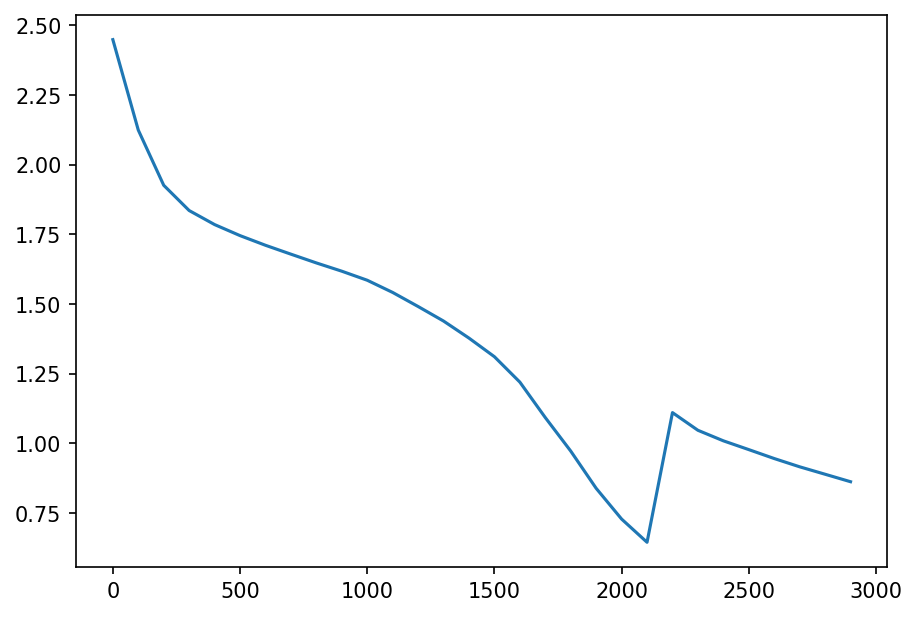

In [ ]:
steps, loss_vals = zip(*losses.items())
plt.plot(steps, loss_vals)

/var/folders/5m/sb0wx83j0m36xk_zswkfnffh0000gn/T/ipykernel_26408/739779758.py:11: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2318.)
  ax1.scatter(*base_samples.T, c="y", s=5)


[Text(0.5, 1.0, 'z $\\to$ x')]

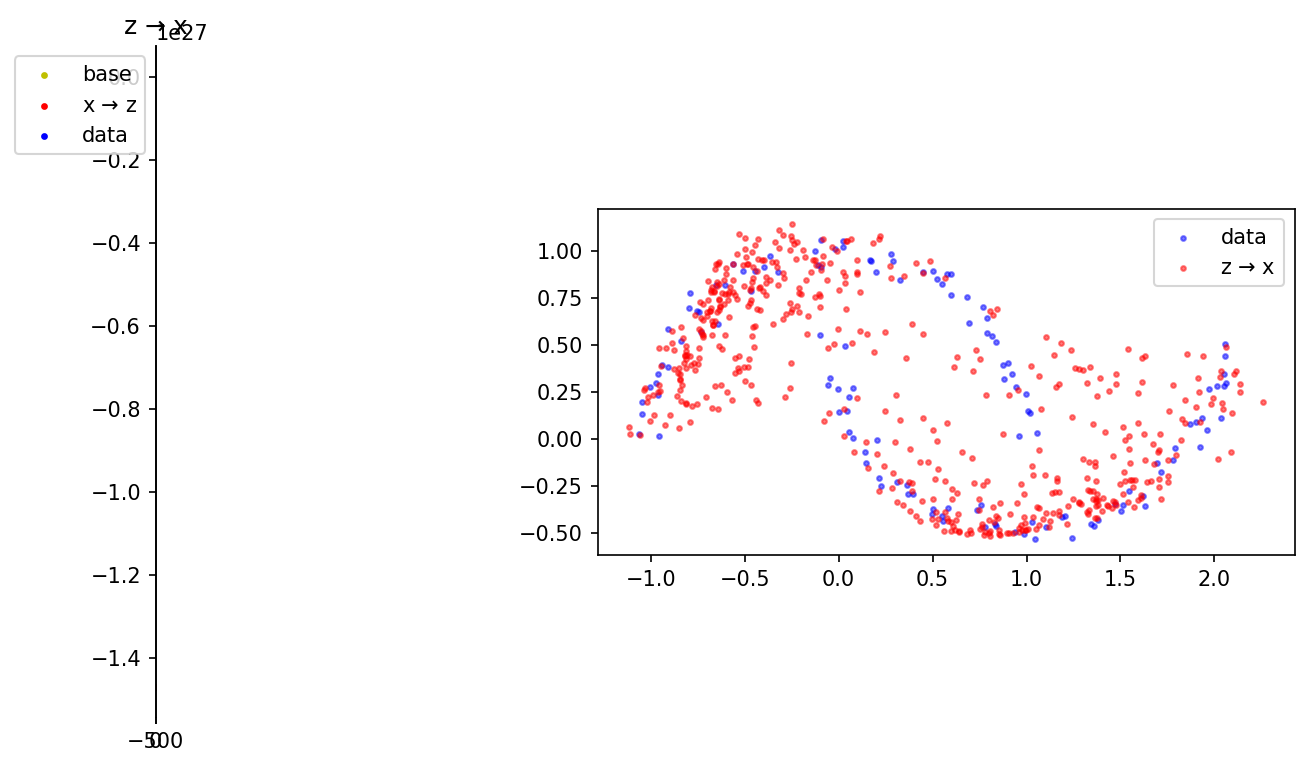

In [ ]:
# draw samples from the target dist and flow them through the model to the base dist
target_samples = sample_target_dist(128)
zs, *_ = model.inverse(target_samples)
target_samples = target_samples.detach().numpy()
z_last = zs[-1].detach().numpy()

# draw samples from the model's base dist to compare how well the model maps real data
# to latent space
base_samples = model.base.sample([128, 2])
_, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(*base_samples.T, c="y", s=5)
ax1.scatter(*z_last.T, c="r", s=5)
ax1.scatter(*target_samples.T, c="b", s=5)
ax1.legend(["base", r"x $\to$ z", "data"])
ax1.axis("scaled")
ax1.set(title=r"x $\to$ z")

# draw samples from the model's output dist and compare with real data
xs = model.sample(128 * 4)
x_last = xs[-1].detach().numpy()
ax2.scatter(*target_samples.T, c="b", s=5, alpha=0.5)
ax2.scatter(*x_last.T, c="r", s=5, alpha=0.5)
ax2.legend(["data", r"z $\to$ x"])
ax2.axis("scaled")
ax1.set(title=r"z $\to$ x")
# plt.savefig(SAVE_TO + "z2x+x2z.pdf", bbox_inches="tight")

In [ ]:
def plot_grid_warp(
    ax: plt.Axes, z: np.ndarray, target_samples: np.ndarray, n_lines: int, idx: int
):
    """plots how the flow warps space"""

    grid = z.reshape((n_lines, n_lines, 2))
    # y coords
    p1 = np.reshape(grid[1:, :, :], (n_lines**2 - n_lines, 2))
    p2 = np.reshape(grid[:-1, :, :], (n_lines**2 - n_lines, 2))
    lcy = LineCollection(tuple(zip(p1, p2)), alpha=0.3)
    # x coords
    p1 = np.reshape(grid[:, 1:, :], (n_lines**2 - n_lines, 2))
    p2 = np.reshape(grid[:, :-1, :], (n_lines**2 - n_lines, 2))
    lcx = LineCollection(tuple(zip(p1, p2)), alpha=0.3)
    # draw the lines
    ax.add_collection(lcx)
    ax.add_collection(lcy)
    ax.axis((-3, 3, -3, 3))
    ax.set_title(f"grid warp after layer {idx + 1}")

    # draw the data too
    plt.scatter(*target_samples.T, c="r", s=5)


def plot_point_flow(ax, z0, z1):
    """plots how the samples travel from one flow to the next"""
    ax.scatter(*z0.T, c="r", s=3, alpha=0.3)
    ax.scatter(*z1.T, c="b", s=3)

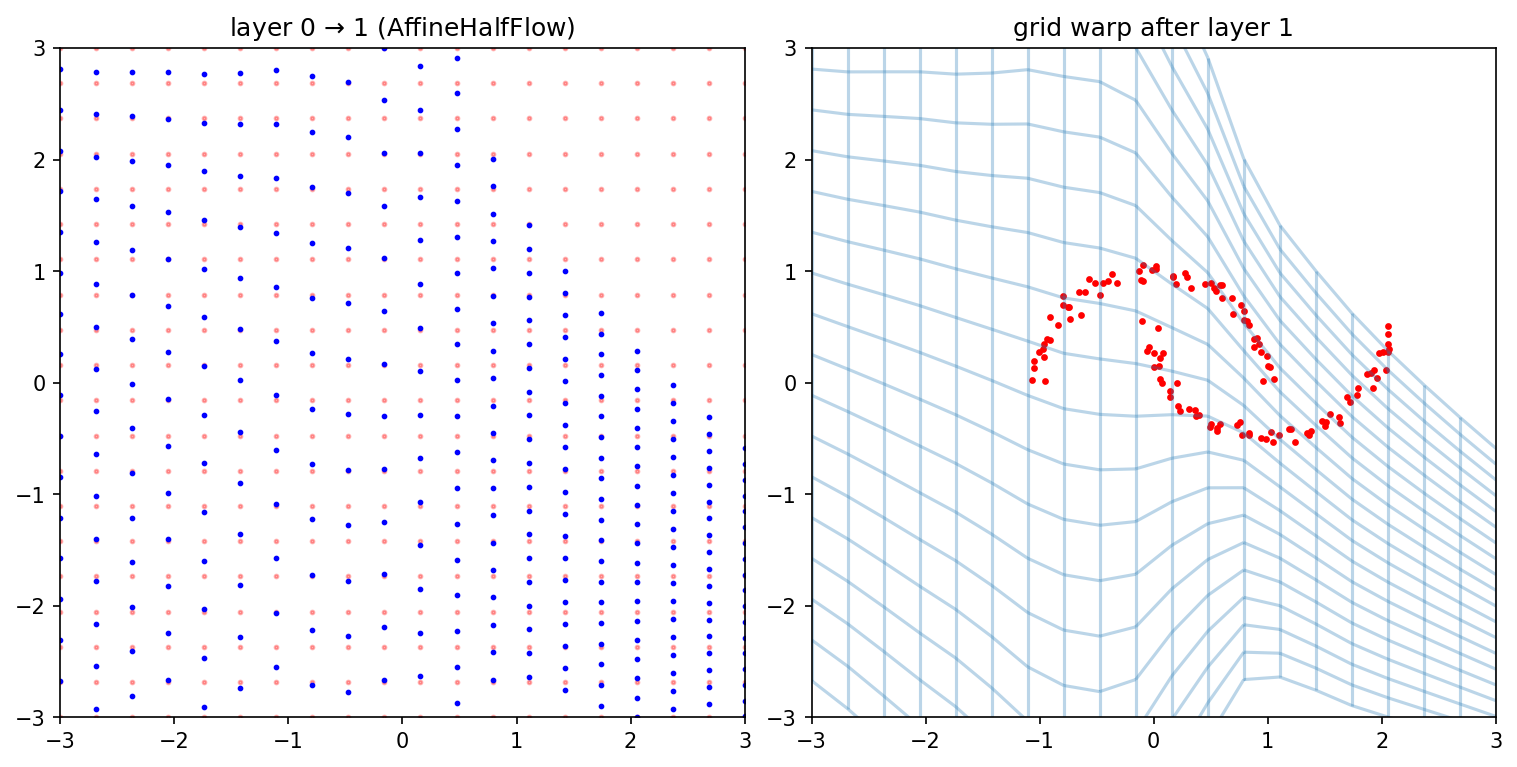

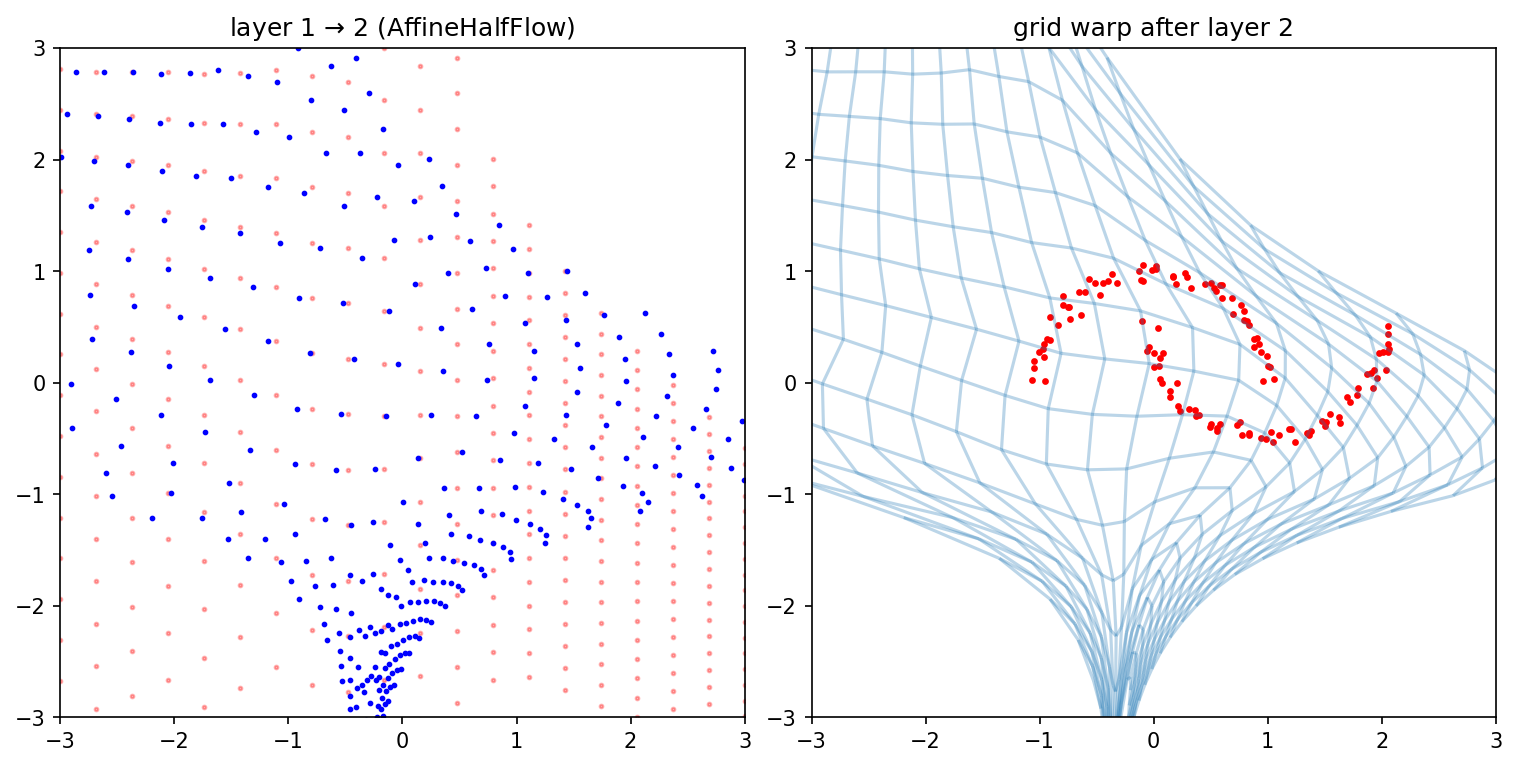

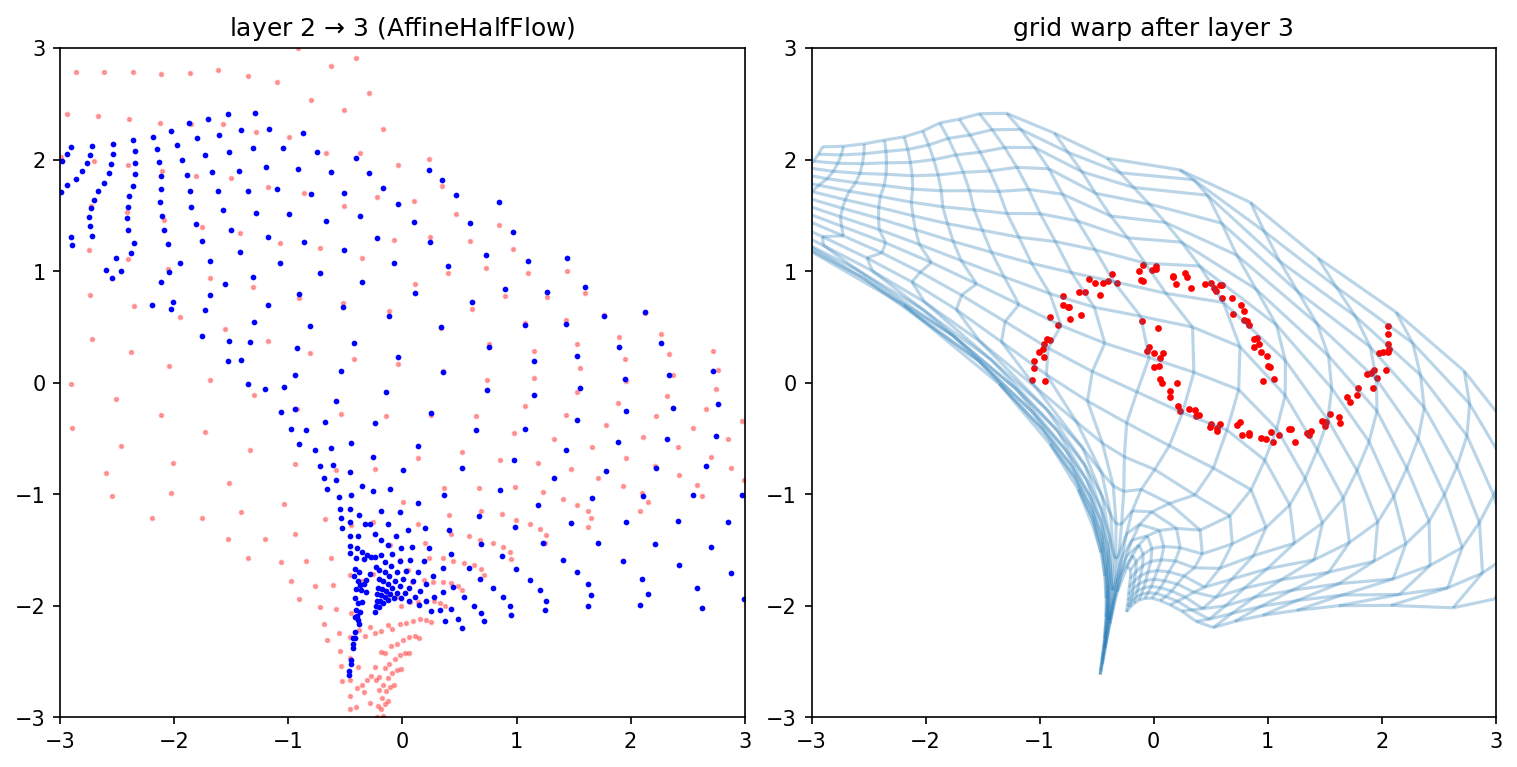

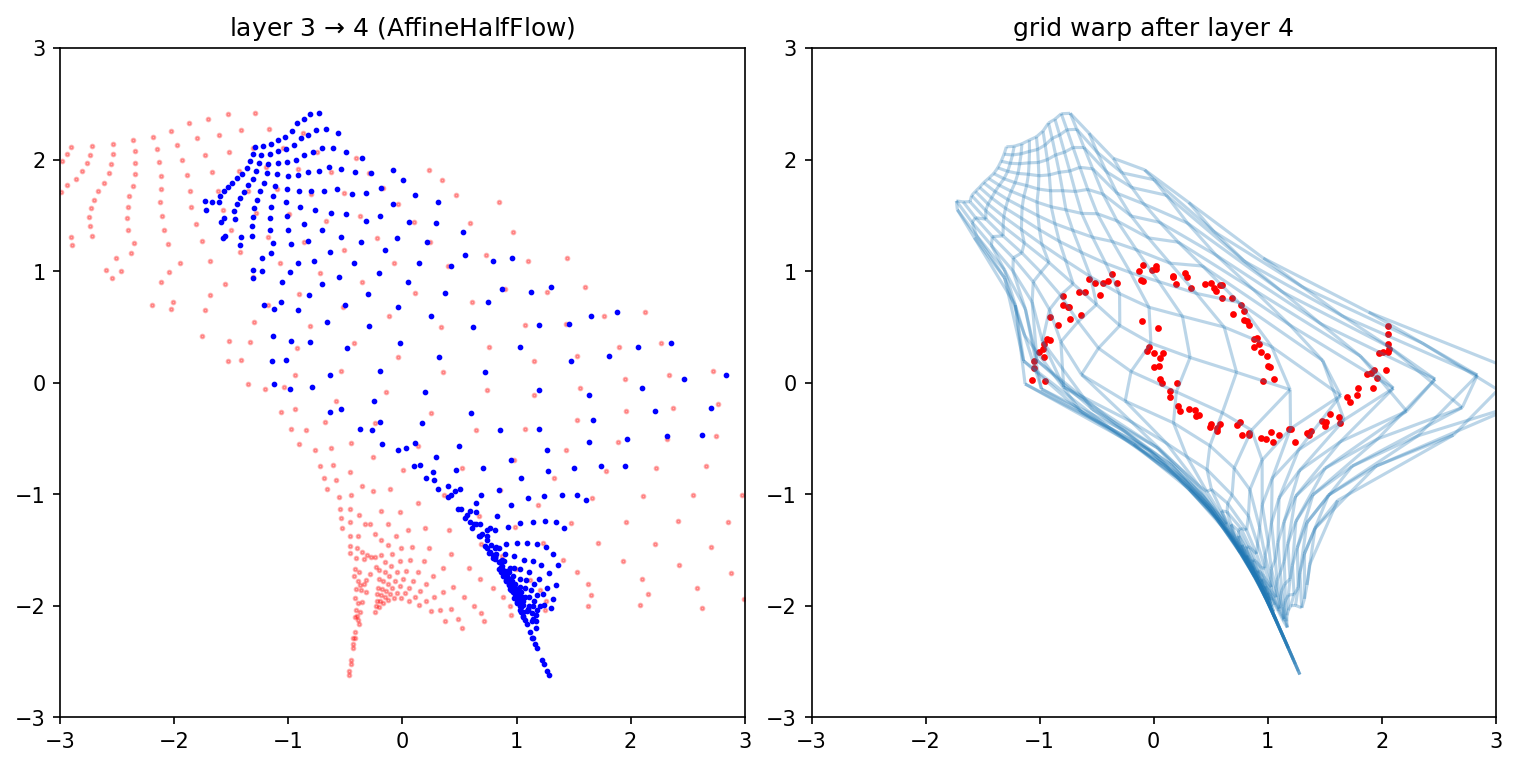

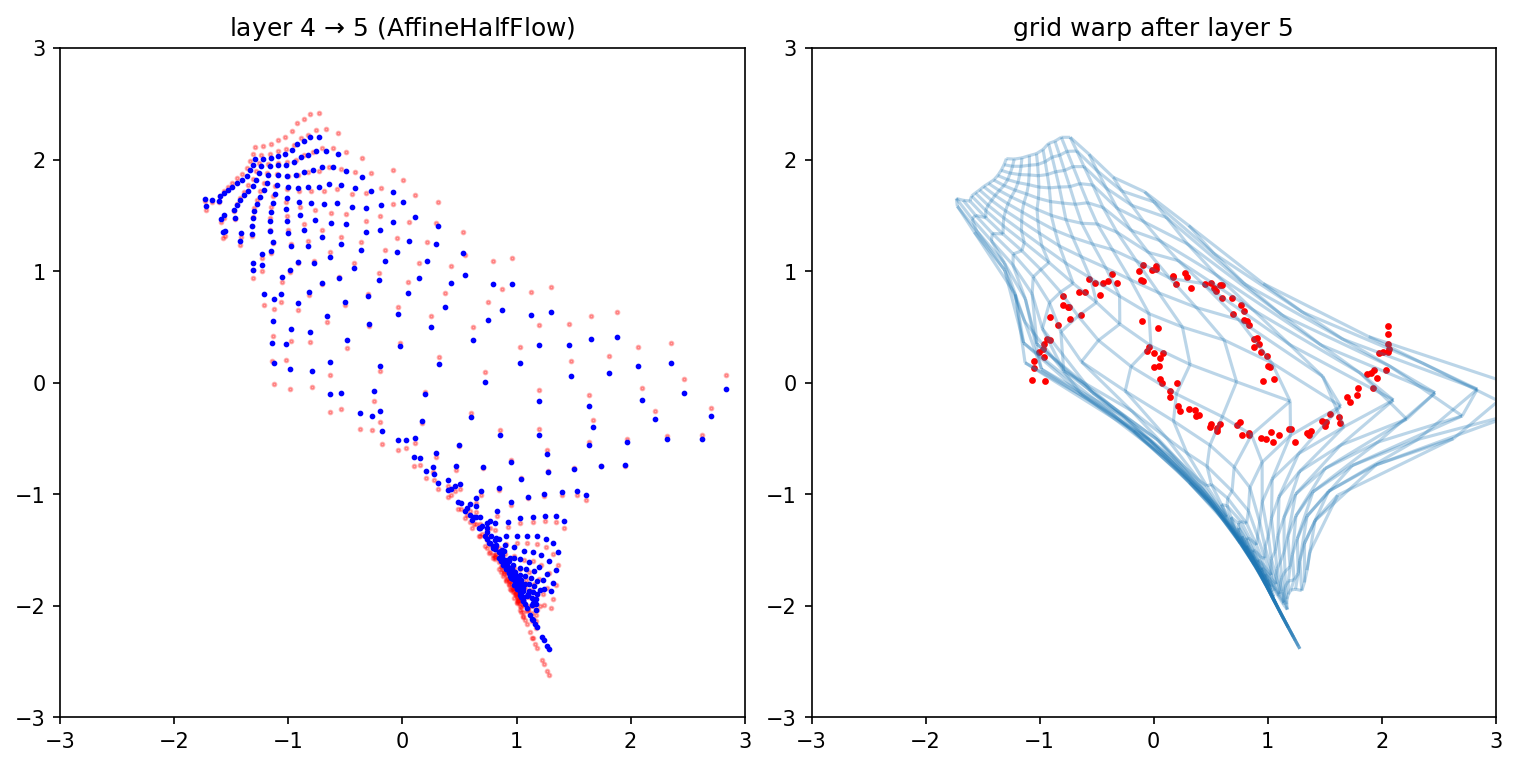

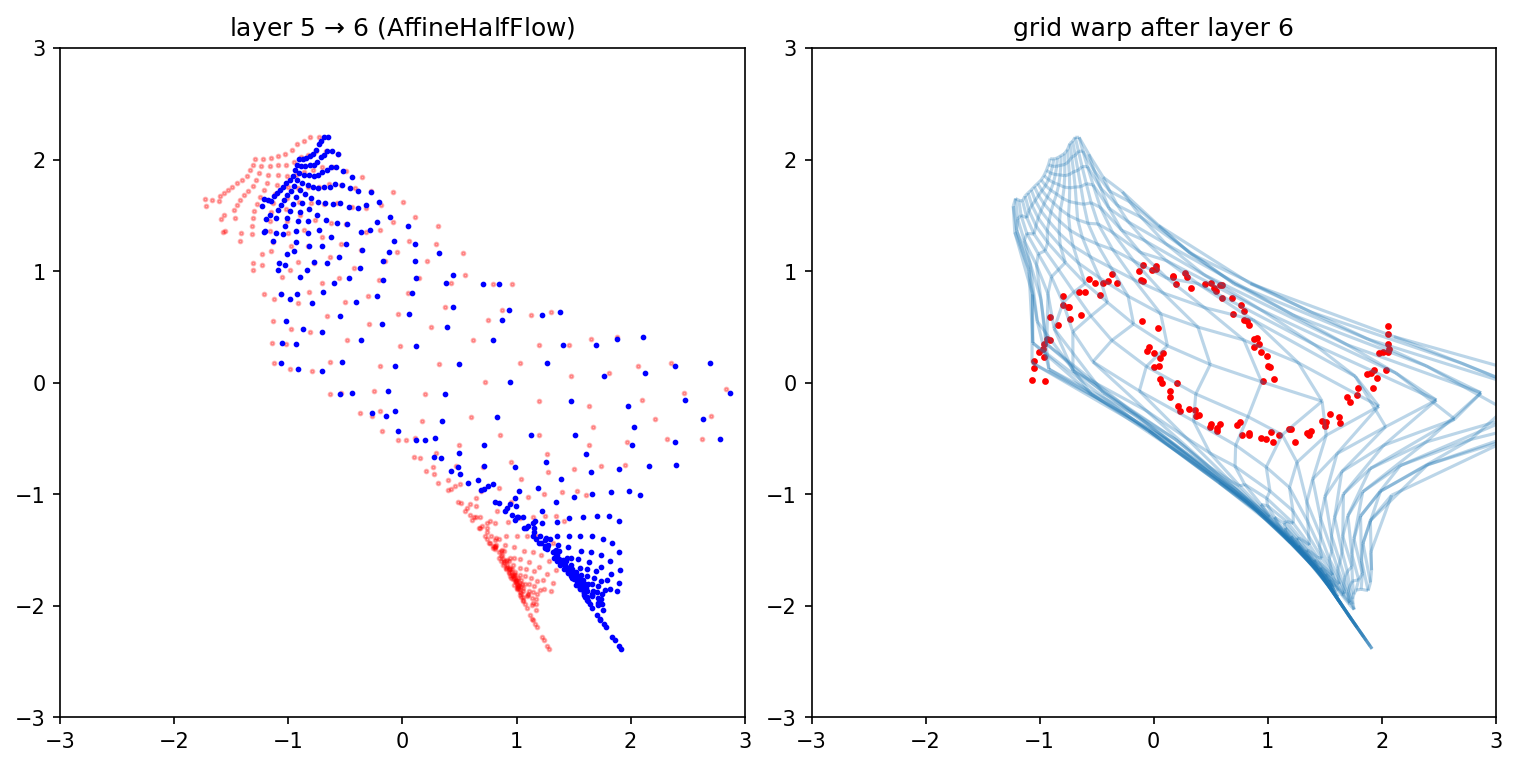

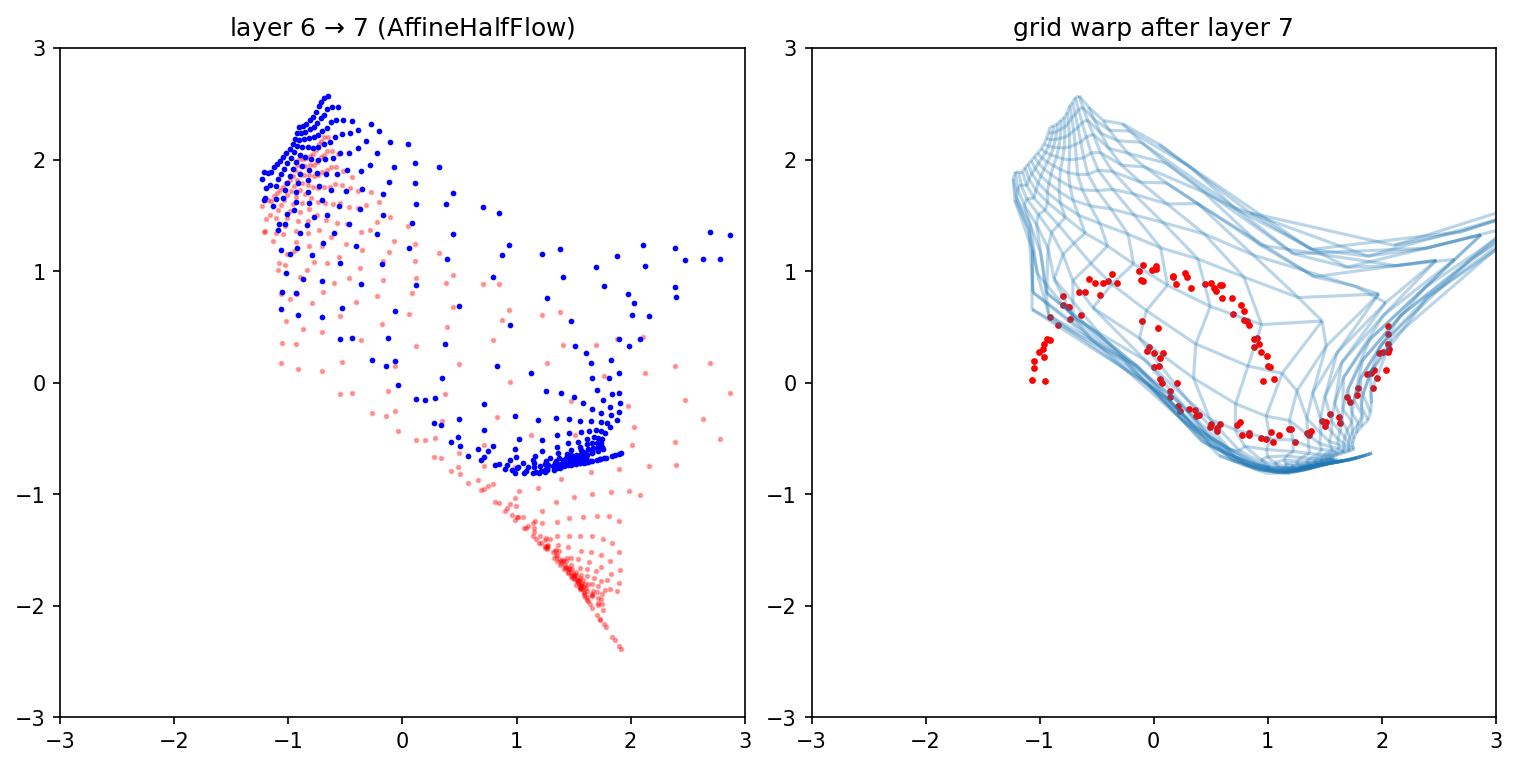

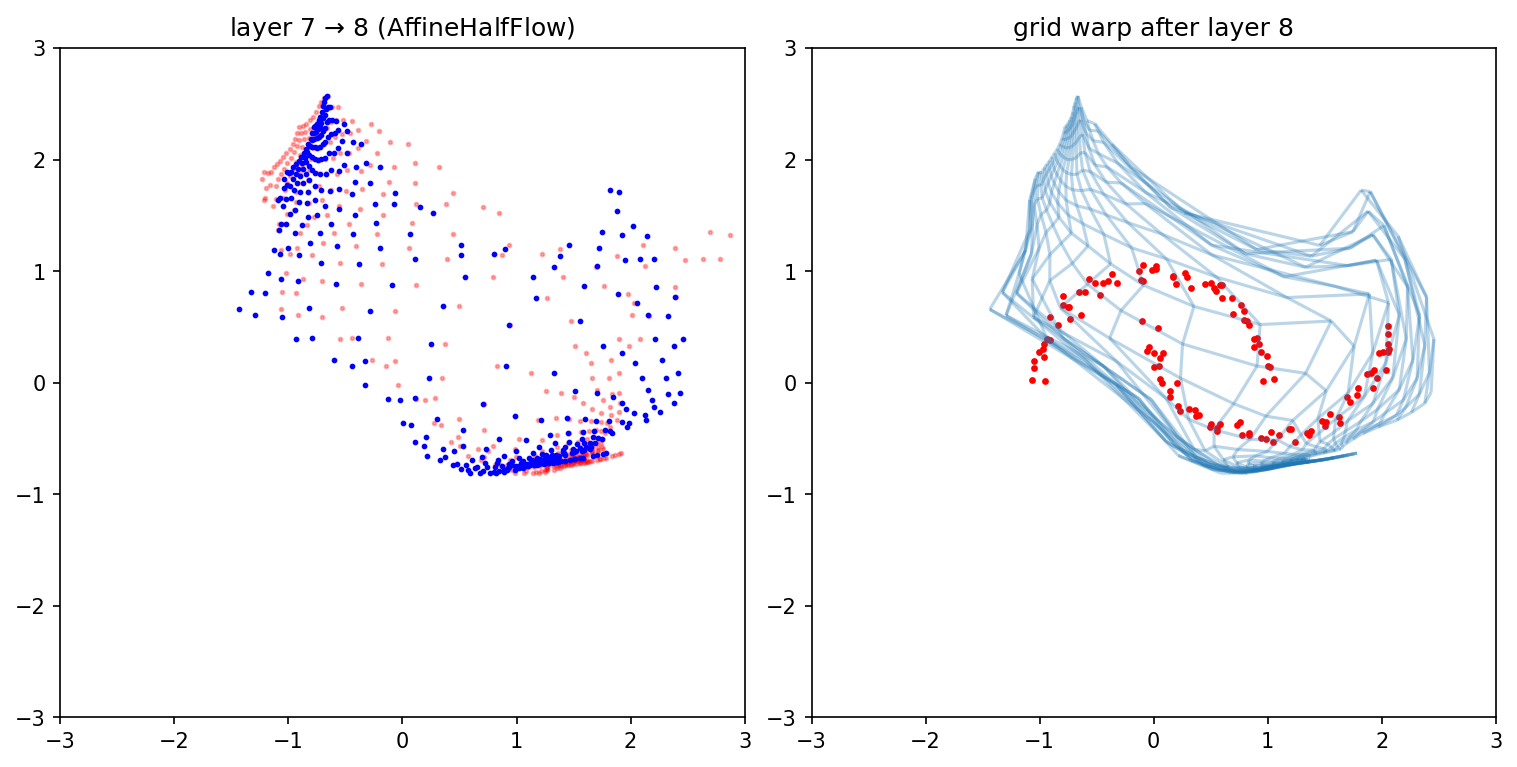

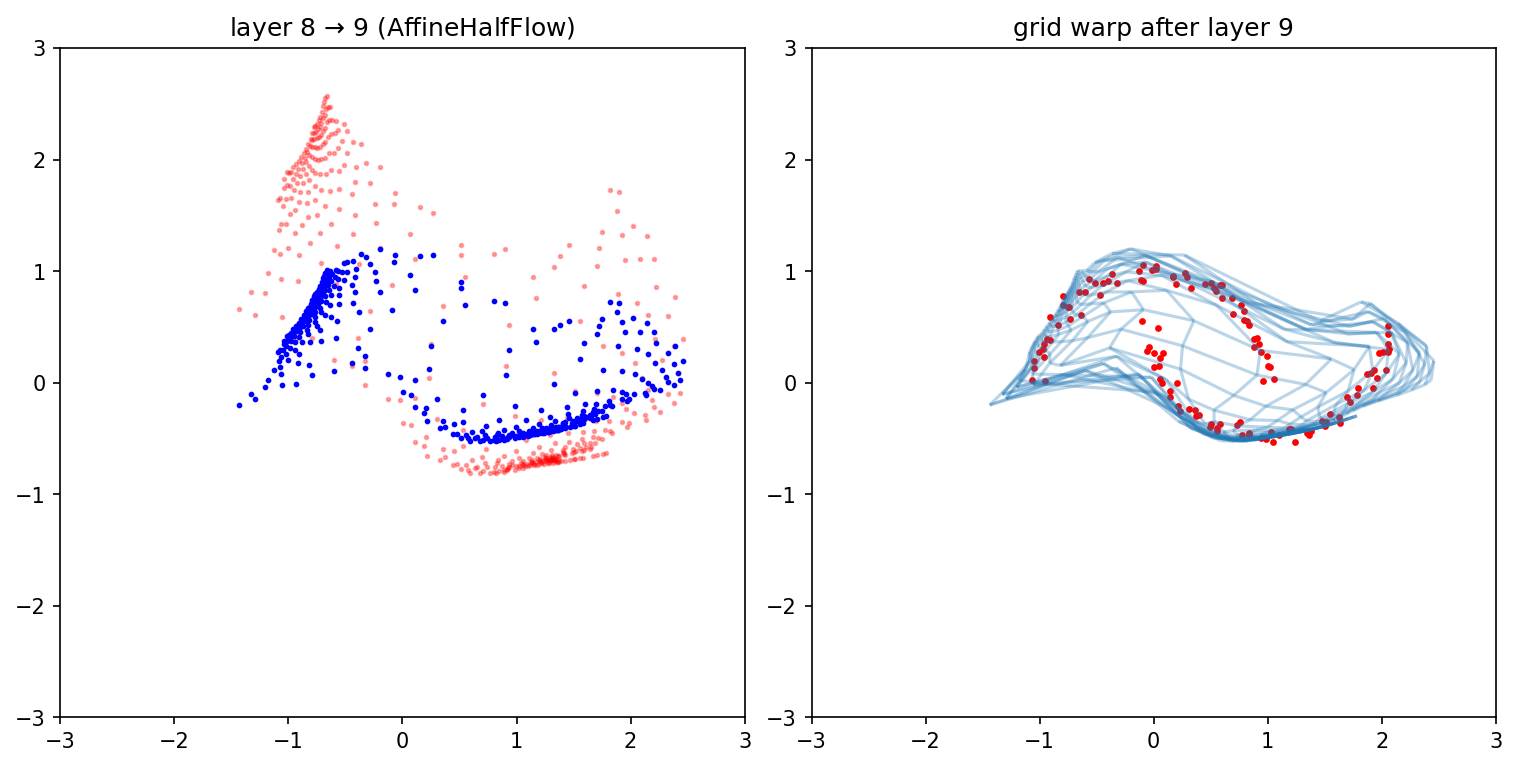

In [ ]:
# plot the coordinate warp
n_grid = 20  # number of grid points
ticks = np.linspace(-3, 3, n_grid)
latent_grid = np.stack(np.meshgrid(ticks, ticks), axis=-1)
# seems appropriate since we use radial distributions as base distributions
in_circle = np.sqrt((latent_grid**2).sum(axis=-1)) <= 3
latent_grid = latent_grid.reshape((n_grid * n_grid, 2))
latent_grid = torch.from_numpy(latent_grid.astype("float32"))

xs, *_ = model.forward(latent_grid)
xs = [z.detach().numpy() for z in xs]

for idx, [z0, z1] in enumerate(zip(xs, xs[1:])):
    _, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))

    plot_point_flow(ax1, z0, z1)
    title = f"layer {idx} $\\to$ {idx + 1} ({model.flows[idx].__class__.__name__})"
    ax1.set(xlim=[-3, 3], ylim=[-3, 3], title=title)

    plot_grid_warp(ax2, z1, target_samples, n_grid, idx)

In [ ]:
# Callback to render progress while training. Do this with an untrained model to see
# significant changes.
def plot_learning():
    xs, _ = model.forward(latent_grid)
    xs = [z.detach().numpy() for z in xs]

    # create a square grid of subplots, one for each step in the flow as many as the
    # largest square that can be filled completely
    plot_grid_height = int(len(model.flows) ** 0.5)
    # plot how the samples travel at this stage
    fig, axes = plt.subplots(plot_grid_height, 2 * plot_grid_height, figsize=(20, 10))
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

    for z0, z1, ax in zip(xs, xs[1:], axes[:, :plot_grid_height].flat):
        plot_point_flow(ax, z0, z1)
        ax.set(xlim=[-4, 4], ylim=[-4, 4], xticks=[], yticks=[])

    big_ax = fig.add_subplot(122)
    plot_grid_warp(big_ax, xs[-1], target_samples, n_grid, len(model.flows) - 1)
    big_ax.set(xlim=[-2, 3], ylim=[-1.5, 2], xticks=[], yticks=[])

    # hide unused axes below the big one
    for ax in axes[:, plot_grid_height:].flat:
        ax.axis("off")

  0%|          | 0/400 [00:00<?, ?it/s, training_loss=inf]/var/folders/5m/sb0wx83j0m36xk_zswkfnffh0000gn/T/ipykernel_26408/2970864336.py:12: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(wspace=0.05, hspace=0.05)
  0%|          | 1/400 [00:00<00:42,  9.49it/s, training_loss=inf]


ValueError: Expected value argument (Tensor of shape (128, 2)) to be within the support (IndependentConstraint(Real(), 1)) of the distribution MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2])), but found invalid values:
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], grad_fn=<CatBackward0>)

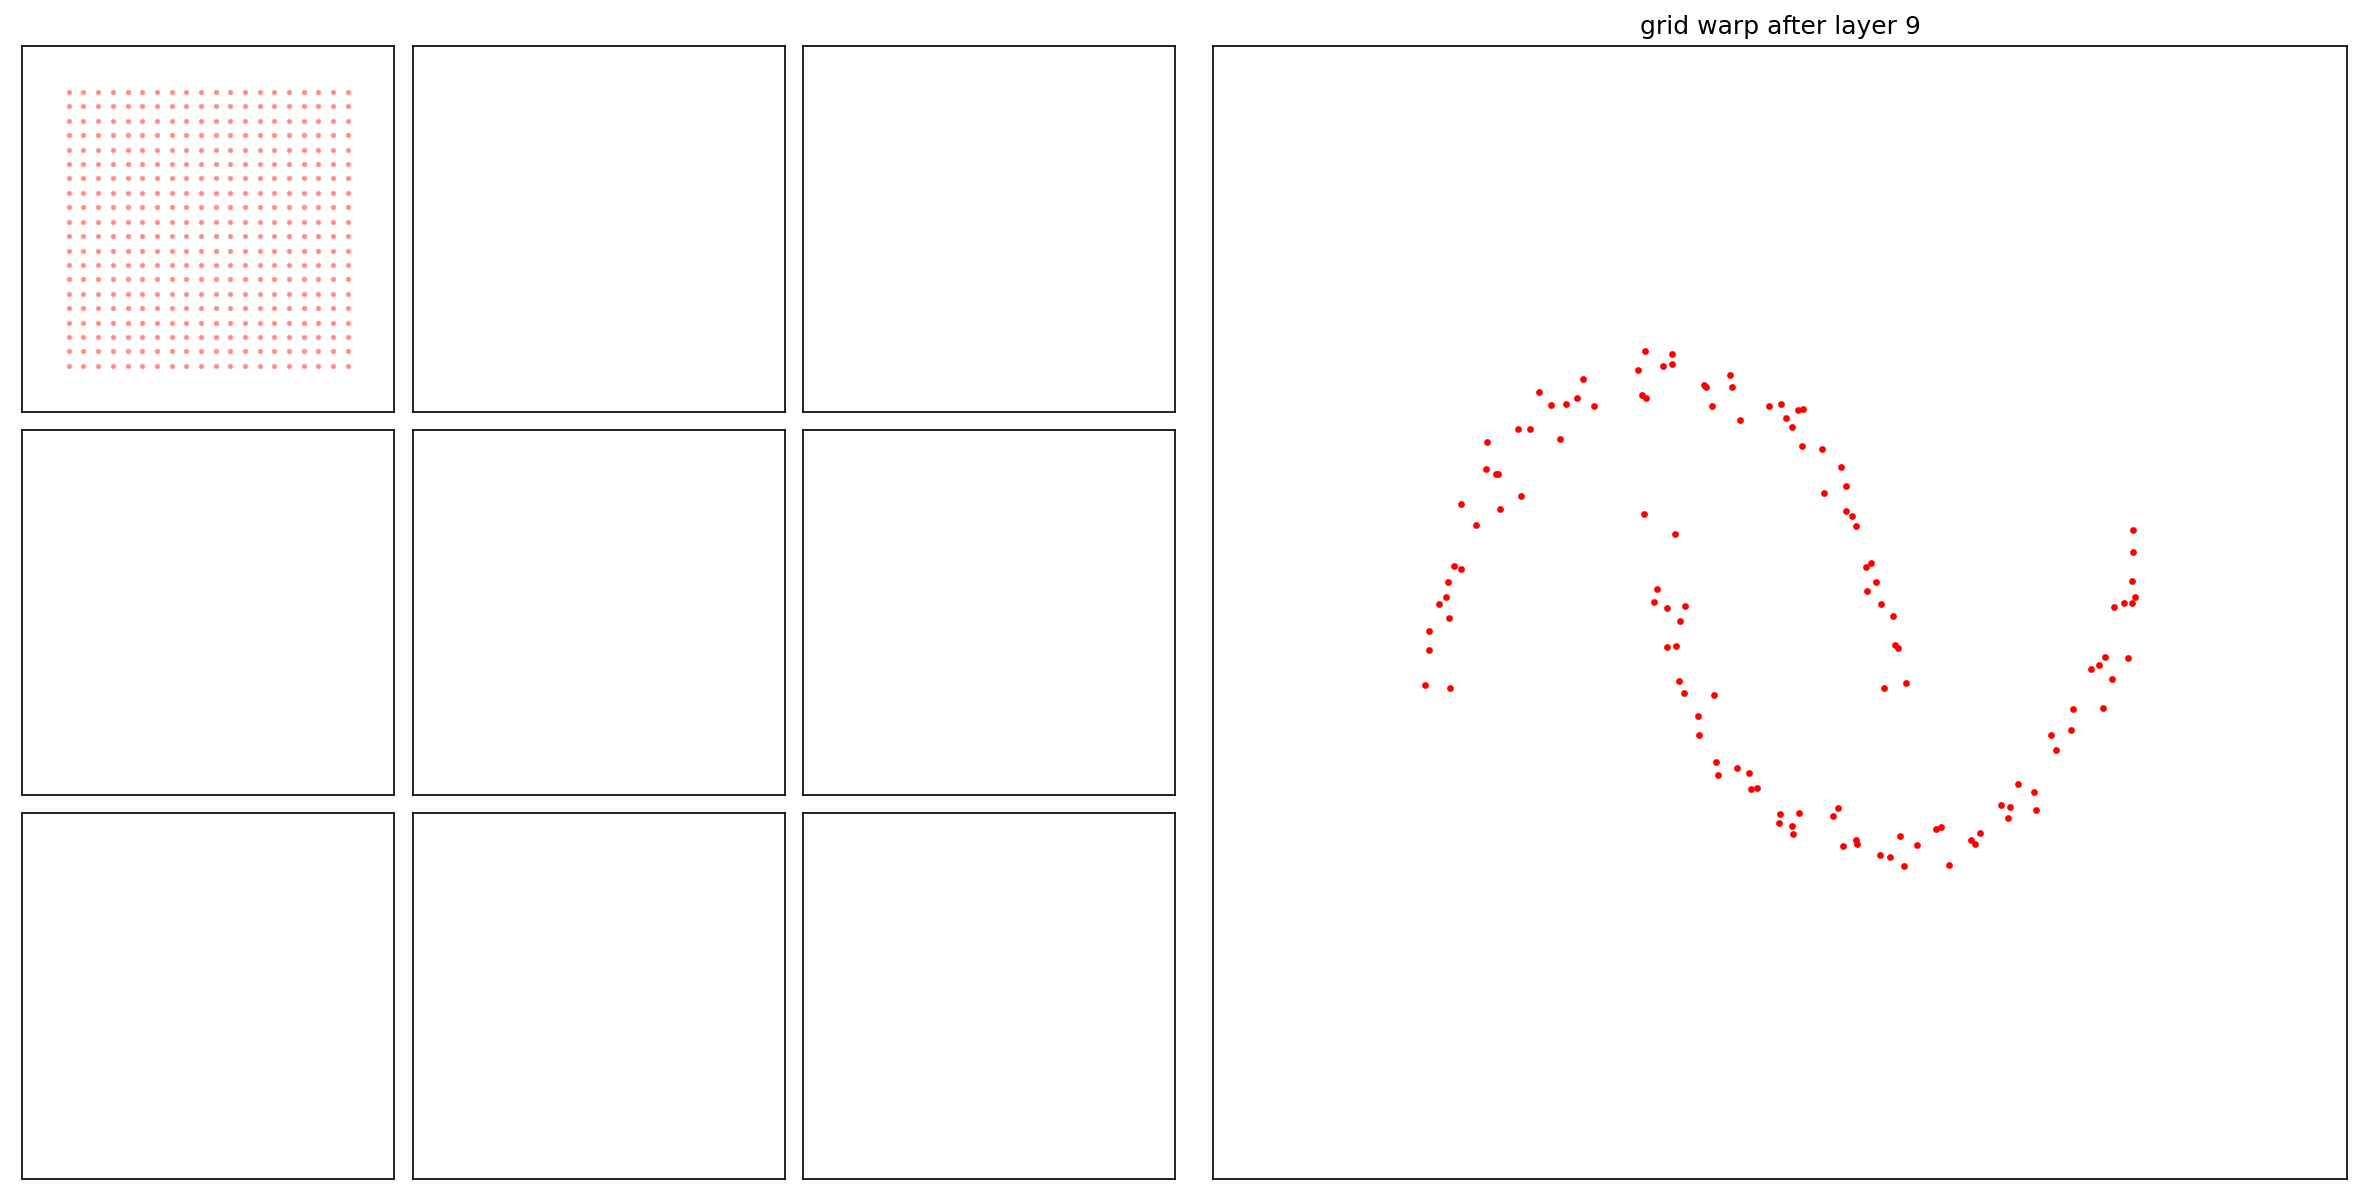

In [ ]:
losses = train_flow(steps=400, cb=plot_learning)
# plt.savefig(SAVE_TO + "point-flow.pdf", bbox_inches="tight")

In [ ]:
# Save model state for later restoring with `checkpoint = torch.load(PATH)`.
# See https://pytorch.org/tutorials/beginner/saving_loading_models#save.
# check_pt = {
#     "step": model.step,
#     "model_state_dict": model.state_dict(),
#     "optimizer_state_dict": optimizer.state_dict(),
#     "loss": losses[-1],
# }
# torch.save(check_pt, SAVE_TO + "checkpoint.pt")